* Train / test / validation
* dropout
* L2 regularization / weight decay

In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from timeit import default_timer as timer

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
print('Using device:\t', device)

Using device:	 cpu


# CIFAR10 dataset

## Preparing the data

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                                    std=(0.5, 0.5, 0.5))])

In [4]:
ds_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

ds_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 16

dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                       shuffle=True, num_workers=0)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,
                                      shuffle=True, num_workers=0)

## Checking the data

In [6]:
def unnormalize(img):
    # Put the data back in the 0-1 range on each channel
    img = img / 2 + 0.5
    # Re-arrange the dimensions 
    # from [batch, channel, width, height] for PyTorch
    # to   [batch, width, height, channel] for Matplotlib imshow
    img = img.permute(0, 2, 3, 1)
    return img

In [7]:
images, labels = next(iter(dl_train))
images = unnormalize(images)

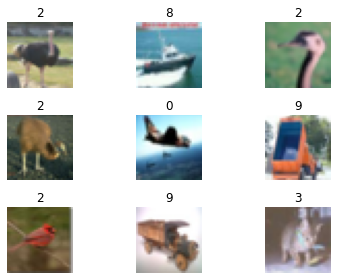

In [8]:
fig1, axs1 = plt.subplots(3, 3)

for i in range(9):
    ax = axs1.flatten()[i]
    im = ax.imshow(images[i].squeeze().numpy())
    ax.set_title(labels[i].item())
    ax.axis('off')
fig1.tight_layout()

# The neural network

## Architecture

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolution step for feature extraction
        self.convolution = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, 1),
            nn.ReLU()
        )
        # Fully connected layers for the end of the network
        self.fully_connected = nn.Sequential(
            nn.Linear(12544, 128),
            nn.Linear(128, 10), # CIFAR10 has 10 categories (digits)
            nn.Softmax(dim=1) # Output the probability
        )

    def forward(self, x):
        x = self.convolution(x) # First goes through the convolutions
        x = torch.flatten(x, 1) # Then reshape (flatten) to go through...
        x = self.fully_connected(x) # ... the fully connected layers
        return x

model_CNN = CNN().to(device)
optimizer = torch.optim.SGD(model_CNN.parameters(), lr=1e-4)

In [10]:
class CNN_advanced(nn.Module):
    def __init__(self):
        super(CNN_advanced, self).__init__()
        # Convolution step for feature extraction
        self.convolution = nn.Sequential(
            # [] to []
            nn.Conv2d(3, 32, 4, 1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Max pooling layer
            # [] to []
            nn.Conv2d(32, 64, 4, 1),
            nn.ReLU(),
            nn.MaxPool2d(2), # Max pooling layer
        )
        # Fully connected layers for the end of the network
        self.fully_connected = nn.Sequential(
            # Input to 128
            nn.Linear(9216, 128),
            nn.ReLU(),
            nn.Dropout(0.2), # Dropout (regularization)
            # 128 to 64
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            # 64 to 32
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            # 32 to 10 (Out)
            nn.Linear(32, 10), # CIFAR10 has 10 categories (digits)
            nn.Softmax(dim=1) # Output the probability
        )

    def forward(self, x):
        x = self.convolution(x) # First goes through the convolutions
        x = torch.flatten(x, 1) # Then reshape (flatten) to go through...
        x = self.fully_connected(x) # ... the fully connected layers
        return x

model_CNN_advanced = CNN_advanced().to(device)
# With momentum (weight decay) for regularization
optimizer_advanced = torch.optim.Adam(model_CNN_advanced.parameters(), lr=1e-4)
# optimizer_advanced = torch.optim.SGD(model_CNN_advanced.parameters(), lr=1e-4, mome

In [11]:
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop

In [12]:
def train(dl_train, dl_test, model, optimizer, loss_fn, device, epochs):
    
    print('training on {}'.format(device))

    accuracy_test_list = []
    t_list = []

    t_start = timer()

    for i in range(epochs):

        # Adjust the weights using training data
        for j, batch in enumerate(dl_train, 0):

            # Process one batch of images
            X_train, y_train = batch
            X_train = X_train.to(device) # Like our GPU tutorial
            y_train = y_train.to(device)

            # Make predictions
            y_pred = model_CNN(X_train)

            # Loss and adjust the weights
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Measure accuracy on test data
        test_acc = 0
        with torch.no_grad():
            for j, batch in enumerate(dl_test, 0):

                X_test, y_test = batch
                X_test = X_test.to(device)
                y_test = y_test.to(device)

                # Make predictions
                y_pred = model_CNN(X_test)

                # Measure the accuracy
                total = y_test.size(0)
                correct = \
                    (torch.argmax(y_pred, dim=1) == y_test).sum().item()
                test_acc += correct / total
                
        test_acc = test_acc / len(dl_test)
        accuracy_test_list.append(test_acc)

        # Timer for a full epoch
        t_end = timer()
        t_list.append(t_end - t_start)
        print('[{}/{}]\tTest accuracy: {:.1%}'.format(i+1, epochs, test_acc))

    return accuracy_test_list, t_list

In [13]:
epochs = 10

In [14]:
accuracy_test_list, t_list = \
    train(dl_train, dl_test, model_CNN, optimizer, loss_fn, device, epochs)

training on cpu
[1/10]	Test accuracy: 10.5%
[2/10]	Test accuracy: 10.6%
[3/10]	Test accuracy: 10.6%
[4/10]	Test accuracy: 10.7%
[5/10]	Test accuracy: 10.8%
[6/10]	Test accuracy: 11.2%
[7/10]	Test accuracy: 11.6%
[8/10]	Test accuracy: 12.3%
[9/10]	Test accuracy: 13.1%
[10/10]	Test accuracy: 14.3%


In [ ]:
accuracy_test_list_advanced, t_list_advanced = \
    train(dl_train, dl_test, model_CNN_advanced, optimizer_advanced, loss_fn, device, epochs)

# Results

In [ ]:
fig1, ax1 = plt.subplots()
ax1.plot(t_list, accuracy_test_list, marker='o', label='Basic CNN')
ax1.plot(t_list_advanced, accuracy_test_list_advanced, marker='o', label='Advanced CNN')
ax1.set(xlabel='Time (s)', ylabel='Test accuracy (%)', ylim=[0,100])
plt.show()